In [1]:
import glob
import pandas as pd 
import numpy as np

import multiprocessing # 여러 개의 일꾼 (cpu)들에게 작업을 분산시키는 역할
from multiprocessing import Pool 
from functools import partial # 함수가 받는 인자들 중 몇개를 고정 시켜서 새롭게 파생된 함수를 형성하는 역할
from data_loader_v2 import data_loader_v2 # 자체적으로 만든 data loader version 2.0 ([데이콘 15회 대회] 데이터 설명 및 데이터 불러오기 영상 참조)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import gc
import joblib # 모델을 저장하고 불러오는 역할

## Load data

In [2]:
# 라벨 데이터 로드
train_label_path = 'data/train_label.csv'
train_label = pd.read_csv(train_label_path, index_col=0)

In [3]:
# 훈련 데이터 리스트 생성 (balanced)
balanced_idx_list = list(train_label.drop_duplicates().index)
train_list = [f'{idx}.csv' for idx in balanced_idx_list]

print(f'>>> number of files in train set : {len(train_list)}\n')
print(f'>>> file names in train set : {train_list}')

train_folder = 'data/train/'

>>> number of files in train set : 198

>>> file names in train set : ['0.csv', '1.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv', '10.csv', '12.csv', '13.csv', '15.csv', '17.csv', '18.csv', '19.csv', '20.csv', '21.csv', '23.csv', '25.csv', '26.csv', '27.csv', '29.csv', '31.csv', '32.csv', '33.csv', '34.csv', '35.csv', '36.csv', '38.csv', '41.csv', '43.csv', '44.csv', '45.csv', '46.csv', '48.csv', '50.csv', '51.csv', '56.csv', '57.csv', '58.csv', '63.csv', '64.csv', '65.csv', '66.csv', '68.csv', '72.csv', '73.csv', '75.csv', '76.csv', '78.csv', '79.csv', '81.csv', '86.csv', '88.csv', '89.csv', '91.csv', '93.csv', '94.csv', '95.csv', '97.csv', '99.csv', '101.csv', '103.csv', '106.csv', '108.csv', '110.csv', '112.csv', '115.csv', '116.csv', '117.csv', '120.csv', '121.csv', '123.csv', '124.csv', '126.csv', '130.csv', '134.csv', '135.csv', '138.csv', '141.csv', '145.csv', '148.csv', '149.csv', '152.csv', '159.csv', '167.csv', '173.csv', '174.csv', '175.csv', '

In [4]:
%%time

# 모든 csv 파일에서 상태_B임이 확실한 15초 이후의 레코드 150개씩 추출
def data_loader_all_v2(func, files, folder='', train_label=None, event_time=15, nrows=165):
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)     
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) 
        df_list = list(pool.imap(func_fixed, files)) 
        pool.close()
        pool.join()        
    combined_df = pd.concat(df_list)    
    return combined_df


train = data_loader_all_v2(data_loader_v2, train_list, folder=train_folder, train_label=train_label)
train = train.loc[:, train.nunique() != 1]  # drop columns that have only one unique value

X_train = train.drop(['label'], axis=1)
y_train = train['label']

X_train.shape, y_train.shape

Wall time: 1min 22s


((29700, 3364), (29700,))

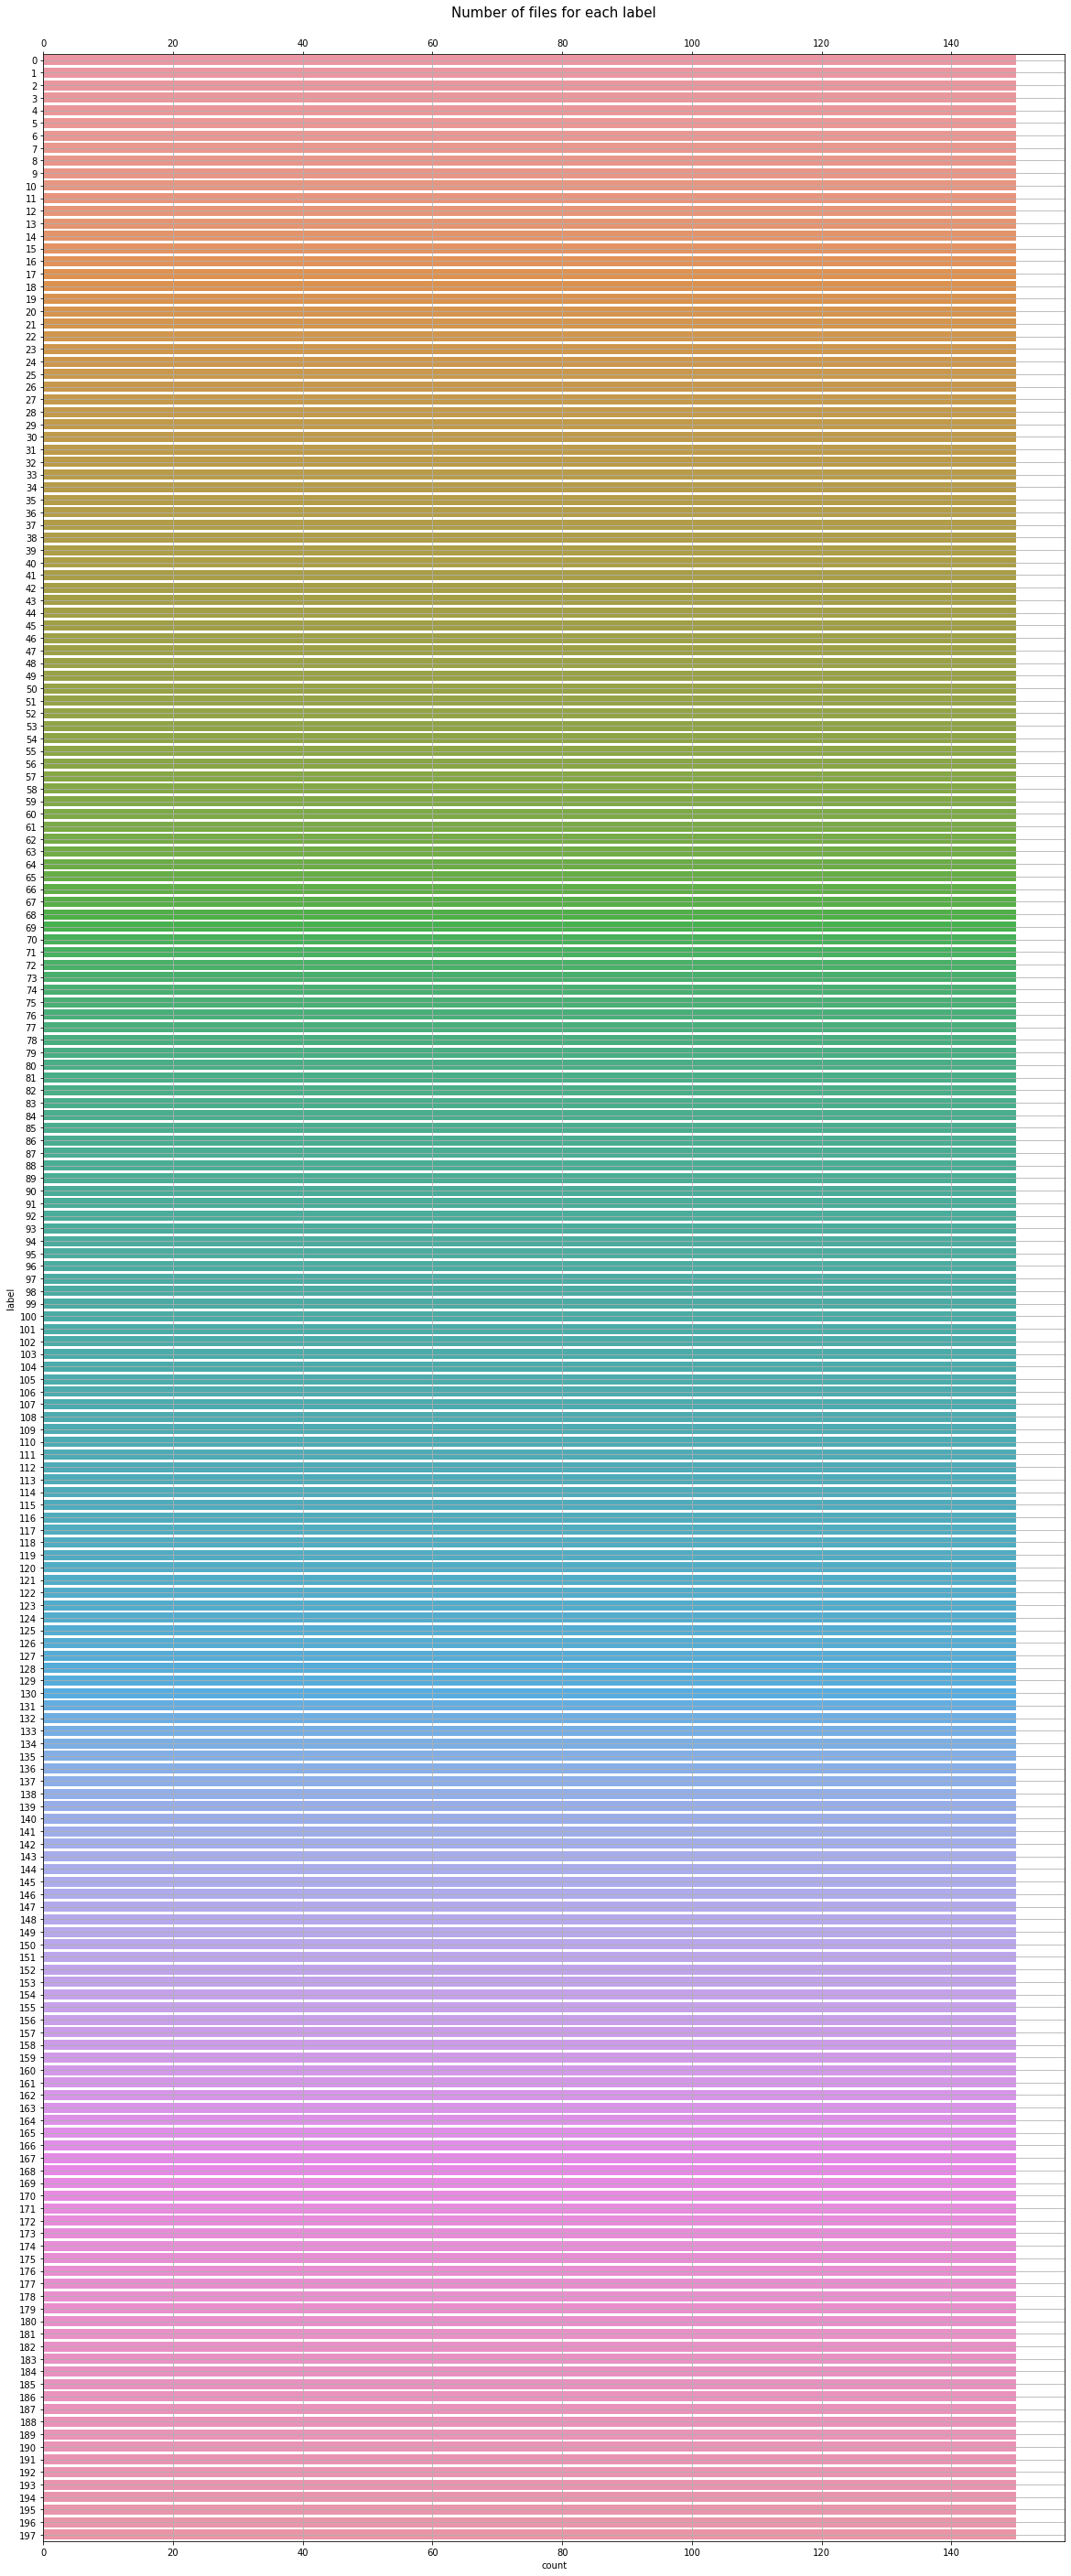

In [5]:
plt.figure(figsize=(20, 50))
sns.countplot(y=y_train)

plt.title('Number of files for each label\n', size=15)
plt.tick_params(labeltop=True, top=True, labelsize=10)
plt.grid()

plt.show()

## Train model (RandomForestClassifier)

In [6]:
gc.collect()  # 메모리 관련 에러 해결

28382

In [7]:
model = RandomForestClassifier(random_state=0, verbose=1, n_jobs=-1,
                               n_estimators=300, min_samples_leaf=5, max_depth=20)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.4min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [8]:
# GridSearchCV - Not run (lack of memory)

# params = {
#     'n_estimators':[100],
#     'max_depth':[8, 12, 50],
#     'min_samples_leaf':[8, 18, 100],
#     'min_samples_split':[8, 20, 100]
# }

# model = RandomForestClassifier(random_state=0, verbose=1, n_jobs=-1)
# grid_cv = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
# grid_cv.fit(X_train, y_train)

# print('best parameter set :\n', grid_cv.best_params_)
# print(f'best accuracy : {grid_cv.best_score_:.4f}')

## Check feature importance

In [9]:
ftr_importances_val = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_val, index=X_train.columns)

# 변수 중요도 0인 컬럼 목록 출력
ftr_importances[ftr_importances==0].index

Index(['V0046', 'V0050', 'V0060', 'V0086', 'V0088', 'V0176', 'V0220', 'V0225',
       'V0226', 'V0229',
       ...
       'V4775', 'V4819', 'V4858', 'V4859', 'V4916', 'V4918', 'V4925', 'V5010',
       'V5014', 'V5115'],
      dtype='object', length=823)

In [10]:
# 변수 중요도 상위 10개 컬럼 출력
ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]
ftr_top10

V4349    0.007581
V4350    0.006703
V4347    0.006663
V0460    0.006607
V4348    0.006602
V0120    0.006268
V4438    0.006259
V1436    0.006019
V0076    0.005764
V4724    0.005738
dtype: float64

## Preprocess data & Save the results

In [11]:
output_df = X_train.loc[:, ftr_importances[ftr_importances!=0].index]  # 변수 중요도가 0인 컬럼 제거
output_df['label'] = y_train  # 라벨 추가
output_df = output_df.reset_index().rename(columns={"index": "file_name"})  # feather 형식으로 저장하기 위해 인덱스 초기화
output_df

,file_name,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,...,V5084,V5085,V5086,V5087,V5088,V5089,V5090,V5118,V5119,label
0,0,30.469574,8.722739,8.686953,8.677701,8.696935,215.779134,148.857105,-8.951266e-20,0.0,...,110.922023,110.958197,-0.298096,-0.234462,-0.241420,-0.164439,43.197957,-0.000003,85.4,110
1,0,30.471422,8.843733,8.724614,8.736648,8.724141,189.935527,186.819255,5.018471e-19,0.0,...,110.918918,110.930774,-0.311288,-0.229316,-0.230339,-0.174198,43.194910,0.000011,85.4,110
2,0,30.465795,8.639923,8.693430,8.706842,8.698667,167.172015,227.642581,5.601811e-19,0.0,...,110.923194,110.877289,-0.275290,-0.247143,-0.175712,-0.179520,43.206854,0.000001,85.4,110
3,0,30.451257,8.643156,8.721100,8.677412,8.697360,190.645984,181.005102,4.328276e-19,0.0,...,110.822725,110.848307,-0.286780,-0.240937,-0.212229,-0.157415,43.198779,0.000004,85.4,110
4,0,30.469449,8.786702,8.718487,8.632532,8.686938,208.447021,202.666961,3.835715e-19,0.0,...,110.810634,110.926518,-0.301789,-0.237373,-0.201726,-0.188566,43.204087,0.000002,85.4,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29695,822,30.442097,8.693186,8.692568,8.714813,8.677127,201.010044,174.534882,-7.379357e-19,0.0,...,110.881929,110.924574,-0.295021,-0.232327,-0.217734,-0.155508,43.191262,0.000005,85.4,134
29696,822,30.467421,8.769116,8.684088,8.755631,8.750314,179.131172,207.915139,-4.998488e-19,0.0,...,110.861569,110.915713,-0.303787,-0.239244,-0.188536,-0.152172,43.199337,-0.000013,85.4,134
29697,822,30.487767,8.868449,8.697357,8.743528,8.726262,206.648694,239.693407,-4.109496e-19,0.0,...,110.864712,110.736746,-0.291943,-0.230015,-0.170520,-0.165963,43.206765,-0.000001,85.4,134
29698,822,30.466411,8.726564,8.720711,8.654625,8.718353,179.336507,194.758045,9.426306e-20,0.0,...,110.830099,110.889551,-0.287461,-0.219087,-0.190229,-0.137458,43.188797,-0.000030,85.4,134


In [12]:
%%time
output_df.to_feather('train_preprocessed.ftr')  # 약 576MB

Wall time: 3.46 s


In [13]:
ftr_importances.to_csv('train_feature_importances.csv')